# Avalanche PMF \(P(S)\) and CCDF with tail fits

**NOTE**: This notebook imports NOS modules from src/. See the repository README section “Running notebooks” for setup.

In [ ]:
# Avalanche PMF P(S) and CCDF + tail fits at rho_s = 50 Hz. avalanche_loglog.png and avalanche_fits_plot.png

import hashlib, numpy as np, numpy.linalg as la, pandas as pd, matplotlib.pyplot as plt
import os
import sys
from pathlib import Path

CWD0 = Path.cwd()
REPO_ROOT = (CWD0.parent if CWD0.name.lower() == "notebooks" else CWD0)
if str(REPO_ROOT) not in sys.path:
    sys.path.insert(0, str(REPO_ROOT))


try:
    from src.nos import NOSParams, NOSState, nos_step
except Exception:  # pragma: no cover
    from nos import NOSParams, NOSState, nos_step

try:
    from src.topology import normalise_to_spectral_radius
except Exception:  # pragma: no cover
    from topology import normalise_to_spectral_radius

try:
    from scipy.stats import norm  # type: ignore
    _norm_cdf = norm.cdf
except Exception:
    from math import erf, sqrt
    def _norm_cdf(z):
        # Standard normal CDF via error function.
        return 0.5 * (1.0 + erf(z / sqrt(2.0)))
    class _Norm:
        cdf = staticmethod(_norm_cdf)
    norm = _Norm()

In [ ]:
# -------- Parameters --
N = 60
T = 20.0
dt = 0.0005
k_near = 1.36
rho_fixed = 50.0
A_list = [0.3, 0.6, 0.9]
I_base = 0.45
bin_ms = 0.005          # 5 ms bin
master_seed = 17
POSITIVE_WEIGHTS = False   # set True if you want strictly excitatory coupling
outdir = os.path.join("outputs", "avalanches_k136_bin6ms")
os.makedirs(outdir, exist_ok=True)


CFG = {
    "N": N, "T": T, "dt": dt, "k_near": k_near, "rho_fixed": rho_fixed,
    "A_list": A_list, "I_base": I_base, "bin_ms": bin_ms, "master_seed": master_seed,
}
print("Run config:", CFG)
with open(os.path.join(outdir, "run_config.json"), "w") as f:
    import json
    json.dump(CFG, f, indent=2)

Run config: {'N': 60, 'T': 20.0, 'dt': 0.0005, 'k_near': 1.36, 'rho_fixed': 50.0, 'A_list': [0.3, 0.6, 0.9], 'I_base': 0.45, 'bin_ms': 0.006, 'master_seed': 17}


In [ ]:
# ------- Utilities ----------------
def child_rng(master_seed, key_tuple):
    h = hashlib.sha256((str(master_seed) + "|" + repr(key_tuple)).encode()).hexdigest()
    return np.random.default_rng(int(h[:16], 16) % (2**63 - 1))

def make_W_rho1(N, rng):
    A = rng.normal(size=(N, N))
    A = 0.5*(A + A.T)
    np.fill_diagonal(A, 0.0)
    if POSITIVE_WEIGHTS:
        A = np.abs(A)
    W_scaled, _rho = normalise_to_spectral_radius(A, 1.0)
    return W_scaled

def simulate_sizes(W, N, T, dt, k, A, rho, rng, bin_ms, I_base):
    # Dynamics (kept consistent with prior threads) but implemented through nos.py.
    # match  original linear drift dv = d0*v - u + syn + I_base + s + noise
    # by setting alpha=0 and choosing (beta - lam - chi) = d0 = -0.6.
    a, b, mu = 1.0, 0.8, 0.5
    d0 = -0.6

    v_th, c, d = 0.6, 0.0, 0.2


    tau_s, A_syn = 0.010, 1.4

    # External shot-noise trace (filtered kicks)
    tau_sn = 0.015
    noise_std = 0.01

    # Map to nos.py parameters so v,u are the NOS state variables.
    p = NOSParams(
        alpha=0.0,
        kappa=0.0,
        beta=0.0,
        gamma=0.0,
        lam=float(-d0),
        chi=0.0,
        v_rest=0.0,
        a=float(a),
        b=float(b),
        mu=float(mu),
        theta=float(v_th),
        thresh_jitter_std=0.0,
        rho_reset=2.0e4,
        c_reset=float(c),
        du_spike=float(d),
        v_clip=None,
    )

    # Initial conditions
    state = NOSState(v=rng.uniform(0.0, 0.2, size=N), u=np.zeros(N, dtype=float))
    x = np.zeros(N, dtype=float)
    s = np.zeros(N, dtype=float)  # shot-noise trace

    p_kick = float(rho) * dt

    bin_steps = int(bin_ms / dt)
    pop_bins = []
    total_spikes = 0
    prev_total_spikes = 0

    steps = int(T / dt)
    for step in range(steps):
        # shot-noise trace
        s -= (dt / tau_sn) * s
        kicks = (rng.random(N) < p_kick)
        s[kicks] += A


        x += dt * (-x / tau_s)
        syn = float(k) * (W @ x)
        I = syn + float(I_base) + s

        additive = dt * rng.normal(0.0, noise_std, size=N)

        state, spk = nos_step(state=state, I=I, dt=dt, p=p, rng=rng, additive_noise=additive)

        if np.any(spk):
            x[spk] += A_syn

        total_spikes += int(np.count_nonzero(spk))
        if (step + 1) % bin_steps == 0:
            bin_count = total_spikes - prev_total_spikes
            assert bin_count <= N * bin_steps
            pop_bins.append(bin_count)
            prev_total_spikes = total_spikes

    # avalanche sizes = sum of spikes across each contiguous run of nonzero bins
    sizes = []
    i = 0
    while i < len(pop_bins):
        if pop_bins[i] > 0:
            s_acc = 0
            while i < len(pop_bins) and pop_bins[i] > 0:
                s_acc += pop_bins[i]
                i += 1
            sizes.append(s_acc)
        else:
            i += 1
    return np.array(sizes, dtype=int)

# Continuous power-law MLE above xmin
def fit_powerlaw_tail(x, xmin):
    x = np.asarray(x, float); x = x[x >= xmin]
    n = x.size
    if n == 0: return np.nan, -np.inf
    alpha = 1.0 + n / np.sum(np.log(x/xmin))
    ll = n*np.log(alpha-1) - n*np.log(xmin) - alpha*np.sum(np.log(x/xmin))
    return alpha, ll

# Truncated log-normal MLE above xmin
def fit_lognormal_tail(x, xmin):
    x = np.asarray(x, float); x = x[x >= xmin]
    if x.size == 0: return np.nan, np.nan, -np.inf
    y = np.log(x); mu = float(np.mean(y)); sigma = float(np.std(y, ddof=0))
    zmin = (np.log(xmin) - mu) / sigma
    C = 1.0 - norm.cdf(zmin)
    ll = -np.sum(np.log(x) + 0.5*np.log(2*np.pi*sigma**2) + (y-mu)**2/(2*sigma**2)) - x.size*np.log(C)
    return mu, sigma, ll

def choose_xmin_ks(x, model="pl", min_tail=30):
    x = np.asarray(x, float)
    cands = np.unique(x[x >= 1])
    best = {"xmin": np.nan, "ks": np.inf, "params": None, "ll": -np.inf, "n": 0}
    for xm in cands:
        tail = x[x >= xm]
        if tail.size < min_tail:
            continue
        if model == "pl":
            alpha, ll = fit_powerlaw_tail(tail, xm)
            F = lambda z: 1 - (np.maximum(z, xm)/xm)**(1-alpha)  # CDF
            params = (alpha,)
        else:
            mu, sigma, ll = fit_lognormal_tail(tail, xm)
            zmin = (np.log(xm)-mu)/sigma
            C = 1.0 - norm.cdf(zmin)
            F = lambda z: np.where(z < xm, 0.0, (norm.cdf((np.log(z)-mu)/sigma) - norm.cdf(zmin))/C)
            params = (mu, sigma)
        zz = np.sort(tail); ecdf = np.arange(1, zz.size+1)/zz.size
        ks = np.max(np.abs(ecdf - F(zz)))
        if ks < best["ks"]:
            best = {"xmin": xm, "ks": ks, "params": params, "ll": ll, "n": tail.size}
    return best

In [ ]:
# --------- Fixed W and simulations ----------------
W = make_W_rho1(N, child_rng(master_seed, ("W", N)))

sizes_by_A = {}
for A in A_list:
    rng = child_rng(master_seed, ("near-threshold", k_near, rho_fixed, A))
    sizes_by_A[A] = simulate_sizes(W, N, T, dt, k_near, A, rho_fixed, rng, bin_ms, I_base)
    np.savetxt(f"{outdir}/avalanche_sizes_A{A:.2f}.txt", sizes_by_A[A], fmt="%d")

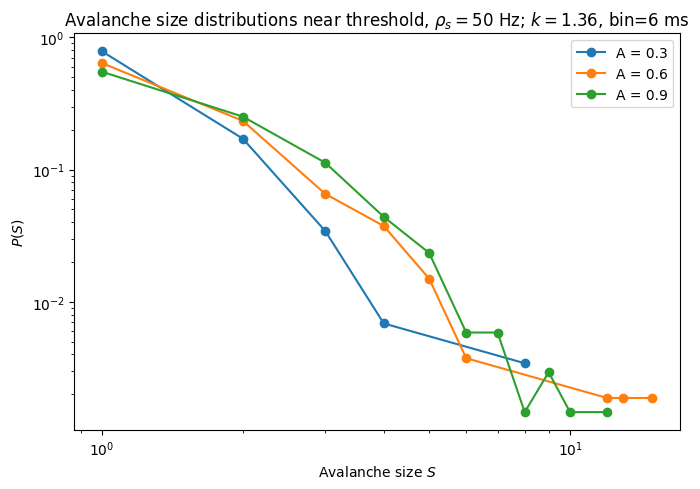

In [ ]:
# ---------------- PMF: P(S) on log–log ------
plt.figure(figsize=(7,5))
for A in A_list:
    s = sizes_by_A[A]
    if s.size == 0:
        continue
    uniq, cnt = np.unique(s, return_counts=True)
    pmf = cnt / cnt.sum()
    plt.loglog(uniq, pmf, marker='o', linestyle='-', label=f"A = {A}")
plt.xlabel("Avalanche size $S$")
plt.ylabel("$P(S)$")
plt.title(f"Avalanche size distributions near threshold, $\\rho_s=50$ Hz; $k={k_near}$, bin={int(bin_ms*1e3)} ms")
plt.legend()
plt.tight_layout()
plt.savefig(f"{outdir}/avalanche_pmf.png", dpi=240)
plt.show()

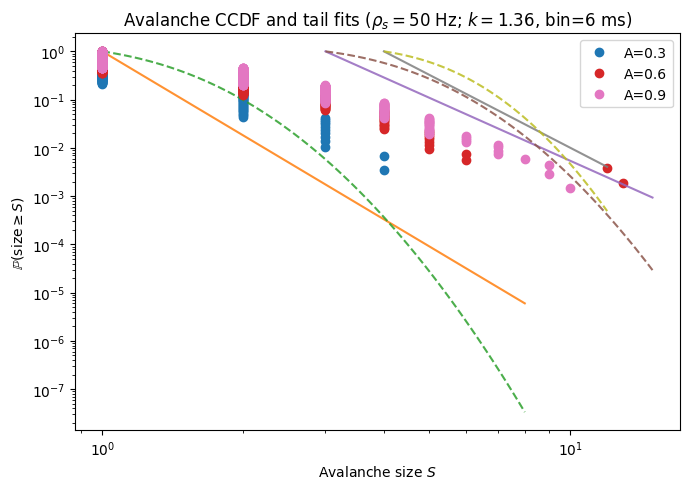

In [ ]:
# ---------- CCDF + tail fits  ----------------
fits_rows = []
plt.figure(figsize=(7,5))
for A in A_list:
    s = sizes_by_A[A]
    if s.size == 0:
        continue
    x = np.sort(s)
    ccdf = 1.0 - (np.arange(1, x.size+1) / x.size)
    plt.loglog(x, ccdf, marker='o', linestyle='none', label=f"A={A}")

    pl = choose_xmin_ks(x, "pl"); ln = choose_xmin_ks(x, "ln")
    # AIC: k_pl=1, k_ln=2
    AIC_pl = 2*1 - 2*pl["ll"] if np.isfinite(pl["ll"]) else np.inf
    AIC_ln = 2*2 - 2*ln["ll"] if np.isfinite(ln["ll"]) else np.inf
    pref = "PL" if AIC_pl < AIC_ln else "LN"

    fits_rows.append({
        "A": A,
        "xmin_PL": pl["xmin"], "n_tail_PL": pl["n"],
        "alpha": (pl["params"][0] if pl["params"] else np.nan),
        "KS_PL": pl["ks"], "LL_PL": pl["ll"], "AIC_PL": AIC_pl,
        "xmin_LN": ln["xmin"], "n_tail_LN": ln["n"],
        "mu": (ln["params"][0] if ln["params"] else np.nan),
        "sigma": (ln["params"][1] if ln["params"] else np.nan),
        "KS_LN": ln["ks"], "LL_LN": ln["ll"], "AIC_LN": AIC_ln,
        "preferred": pref
    })

    # overlays above xmin
    for model, res, style in [("pl", pl, "-"), ("ln", ln, "--")]:
        xm = res["xmin"]
        if not np.isfinite(xm):
            continue
        xx = np.unique(np.logspace(np.log10(xm), np.log10(max(x)), num=80))
        if model == "pl":
            alpha = res["params"][0]
            F = 1 - (xx/xm)**(1-alpha)                # CDF
        else:
            mu, sigma = res["params"]
            zmin = (np.log(xm)-mu)/sigma
            C = 1.0 - norm.cdf(zmin)
            F = (norm.cdf((np.log(xx)-mu)/sigma) - norm.cdf(zmin)) / C
        plt.loglog(xx, 1.0 - F, style, alpha=0.85)

plt.xlabel("Avalanche size $S$")
plt.ylabel(r"$\mathbb{P}(\mathrm{size}\geq S)$")
plt.title(f"Avalanche CCDF and tail fits ($\\rho_s=50$ Hz; $k={k_near}$, bin={int(bin_ms*1e3)} ms)")
plt.legend()
plt.tight_layout()
plt.savefig(f"{outdir}/avalanche_ccdf_fits.png", dpi=240)
plt.show()

In [ ]:
# ---------------- Save fit table ----------------
df_fits = pd.DataFrame(fits_rows)
df_fits.to_csv(f"{outdir}/avalanche_fits_table.csv", index=False)
df_fits

,A,xmin_PL,n_tail_PL,alpha,KS_PL,LL_PL,AIC_PL,xmin_LN,n_tail_LN,mu,sigma,KS_LN,LL_LN,AIC_LN,preferred
0,0.3,1.0,292,6.782692,0.784247,169.926334,-337.852669,1.0,292,0.172930,0.348812,0.784247,-48.922033,101.844066,PL
1,0.6,3.0,68,5.334355,0.514706,-58.667300,119.334601,3.0,68,1.329327,0.337515,0.514706,-93.722114,191.444229,PL
2,0.9,4.0,59,6.016780,0.508475,-57.397386,116.794772,4.0,59,1.585625,0.266965,0.508475,-84.111991,172.223983,PL
